In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time
import warnings
from collections import deque
import psutil
import os

In [2]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [105]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 

TARGET_MODULATIONS = ['4ASK', 'BPSK', 'QPSK', '8PSK','16PSK', '16QAM', '64QAM' ]

BATCH_SIZE = 256 # adjust to my laptop 
#LEARNING_RATE = 0.003 
NUM_EPOCHS = 100 
NUM_WORKERS = 0 #Temporary check it  

INPUT_CHANNELS = 2 
SEQUENCE_LENGTH = 1024 
NUM_CLASSES = 7 # adjust this to 

# TRAIN_RATIO = 0.7 
# VALID_RATIO = 0.2 
# TEST_RATIO = 0.1 

nf_train = int(BATCH_SIZE * 0.7)
nf_valid = int(BATCH_SIZE * 0.2)
nf_test  = BATCH_SIZE - nf_train - nf_valid

print("📋 Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
#print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

📋 Training Parameters:
  Batch size: 256
  Epochs: 100


In [106]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.8, # training 70 %
                  valid_proportion=0.2, # validation 20 %
                  test_proportion=0.0, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [107]:
class RadioML18Dataset(Dataset):
    def __init__(self, mode: str,use_fft: bool = False, seed=48,):
        super(RadioML18Dataset, self).__init__()

        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft 
        try:
            hdf5_file = h5py.File(self.file_path, 'r') #Escaped backslashes 
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except Exception as e: 
            print(f"Error loading file : {e}")
            raise e 
        
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]

        train_proportion=(11*26*nf_train)/self.X.shape[0]
        valid_proportion=(11*26*nf_valid)/self.X.shape[0]
        test_proportion=(11*26*nf_test)/self.X.shape[0]

        self.target_snrs = np.unique(self.Z)

        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_proportion,
                                                                  valid_proportion = valid_proportion,
                                                                  test_proportion = test_proportion,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )

        # *** CRITICAL FIX: Apply I/Q swap correction for AMC compatibility ***
        print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
 
        self.X_data = self.X_data[:,:,[1,0]]
        print(f"✅ I/Q channels corrected for real-world compatibility")
        if self.use_fft:
            print("Dataset configured to use FFT as input")

        # store statistic of whole dataset (unchanged)
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x_raw,y,z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        
        # convert to tensor adn transpose to (channels and sequence length)
        x = torch.from_numpy(x_raw).float().transpose(0,1)

        if self.use_fft: 
            complex_signal = torch.complex(x[0],x[1])
            fft_result = torch.fft.fft(complex_signal)

            fft_real = torch.real(fft_result)
            fft_imag = torch.imag(fft_result)

            x = torch.stack([fft_real,fft_imag], dim = 0)
        
        return x,y,z

In [108]:
class RadioMLIQDataset(Dataset):
    """Dataset class for RadioML18 data formatted for CNNIQModel dual-branch architecture.
    
    Loads RadioML18 HDF5 data and returns separate I and Q tensors in 2D format
    suitable for CNNIQModel's separate branch processing.
    """
    
    def __init__(self, mode: str, use_fft: bool = False, seed: int = 48):
        """Initialize RadioMLIQDataset.
        
        Args:
            mode: Dataset split mode ('train', 'valid', or 'test').
            use_fft: Whether to apply FFT transformation to signals.
            seed: Random seed for dataset splitting.
            
        Raises:
            FileNotFoundError: If HDF5 or JSON files cannot be found.
            ValueError: If mode is not valid or data dimensions are incompatible.
        """
        super(RadioMLIQDataset, self).__init__()
        
        # Configuration (you'll need to define these constants)
        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode
        
        # Validate mode
        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"Mode must be 'train', 'valid', or 'test', got '{mode}'")
        
        # Load data files
        try:
            self.hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Error loading data files: {e}")
        except Exception as e:
            print(f"Error loading file: {e}")
            raise e
        
        # Load raw data
        self.X = self.hdf5_file['X']
        self.Y = np.argmax(self.hdf5_file['Y'], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]
        
        # Calculate proportions for dataset splitting
        train_proportion = (7 * 26 * nf_train) / self.X.shape[0]
        valid_proportion = (7 * 26 * nf_valid) / self.X.shape[0]
        test_proportion = (7 * 26 * nf_test) / self.X.shape[0]
        
        self.target_snrs = np.unique(self.Z)
        
        # Split dataset
        self.X_data, self.Y_data, self.Z_data = dataset_split(
            data=self.X,
            modulations_classes=self.modulation_classes,
            modulations=self.Y,
            snrs=self.Z,
            mode=mode,
            train_proportion=train_proportion,
            valid_proportion=valid_proportion,
            test_proportion=test_proportion,
            target_modulations=self.target_modulations,
            target_snrs=self.target_snrs,
            seed=seed
        )
        
        # Apply I/Q swap correction for AMC compatibility
        print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
        self.X_data = self.X_data[:, :, [1, 0]]
        print(f"✅ I/Q channels corrected for real-world compatibility")
        
        # Validate signal length for 2D reshaping
        signal_length = self.X_data.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024 for 32x32 reshape, got {signal_length}")
        
        if self.use_fft:
            print("Dataset configured to use FFT as input")
        
        # Store dataset statistics
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
        print(f"RadioMLIQDataset {mode}: {self.num_data} samples, "
              f"{self.num_lbl} classes, {self.num_snr} SNR levels")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset.
        
        Returns:
            Number of samples.
        """
        return self.X_data.shape[0]
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int, float]:
        """Get a sample from the dataset.
        
        Args:
            idx: Sample index.
            
        Returns:
            Tuple of (i_tensor, q_tensor, label, snr) where:
                - i_tensor: I signal as 2D tensor (1, 32, 32)
                - q_tensor: Q signal as 2D tensor (1, 32, 32) 
                - label: Modulation class label
                - snr: Signal-to-noise ratio
                
        Raises:
            IndexError: If idx is out of range.
        """
        if idx >= len(self) or idx < 0:
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self)}")
        
        # Get raw data
        x_raw, y, z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        
        # Convert to tensor and transpose to (channels, sequence_length)
        x = torch.from_numpy(x_raw).float().transpose(0, 1)  # Shape: (2, 1024)
        
        # Apply FFT if requested
        if self.use_fft:
            complex_signal = torch.complex(x[0], x[1])
            fft_result = torch.fft.fft(complex_signal)
            fft_real = torch.real(fft_result)
            fft_imag = torch.imag(fft_result)
            x = torch.stack([fft_real, fft_imag], dim=0)
        
        # Separate I and Q signals
        i_signal = x[0]  # Shape: (1024,)
        q_signal = x[1]  # Shape: (1024,)
        
        # Reshape 1D signals to 2D (32x32) and add channel dimension
        i_2d = i_signal.view(1, 32, 32)  # Shape: (1, 32, 32)
        q_2d = q_signal.view(1, 32, 32)  # Shape: (1, 32, 32)
        
        return i_2d, q_2d, y, z
    
    def get_signal_stats(self) -> dict:
        """Get statistics about the signals in the dataset.
        
        Returns:
            Dictionary with signal statistics.
        """
        # Sample a few signals to compute stats
        sample_indices = np.random.choice(len(self), min(1000, len(self)), replace=False)
        i_values = []
        q_values = []
        
        for idx in sample_indices:
            i_2d, q_2d, _, _ = self[idx]
            i_values.append(i_2d.flatten())
            q_values.append(q_2d.flatten())
        
        i_all = torch.cat(i_values)
        q_all = torch.cat(q_values)
        
        return {
            'i_mean': float(i_all.mean()),
            'i_std': float(i_all.std()),
            'i_min': float(i_all.min()),
            'i_max': float(i_all.max()),
            'q_mean': float(q_all.mean()),
            'q_std': float(q_all.std()),
            'q_min': float(q_all.min()),
            'q_max': float(q_all.max()),
            'signal_shape': '(1, 32, 32)',
            'num_samples': len(self)
        }
    
    def close(self):
        """Close the HDF5 file handle."""
        if hasattr(self, 'hdf5_file'):
            self.hdf5_file.close()
    
    def __del__(self):
        """Cleanup when object is destroyed."""
        self.close()

In [109]:
try:
    from BaseCNN import create_BaseCNN_NET

    # Match the real signature: (n_labels, dropout_rate)
    model = create_BaseCNN_NET(n_labels=NUM_CLASSES, dropout_rate=0.5).to(device)
    print("✅ Successfully built BaseCNN:", model)

except Exception as e:
    print(f"⚠️ Could not build BaseCNN: {e}")

✅ Successfully built BaseCNN: BaseCNN_NET(
  (backbone): Sequential(
    (0): BaseCNN_Block(
      (block): Sequential(
        (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Dropout(p=0.2, inplace=False)
      )
    )
    (1): BaseCNN_Block(
      (block): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): Batch

In [110]:
try:
    from ComplexCNN import create_complex_model

    # Match the real signature: (n_labels, dropout_rate)
    model_complex = create_complex_model(n_labels=NUM_CLASSES, dropout_rate=0.6).to(device)
    print("✅ Successfully built Complex CNN:", model_complex)

except Exception as e:
    print(f"⚠️ Could not build COmplex CNN: {e}")

✅ Successfully built Complex CNN: ComplexCNN_NET(
  (backbone): Sequential(
    (0): ComplexCNN_Block(
      (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.18, inplace=False)
    )
    (1): ComplexCNN_Block(
      (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(

In [111]:
try:
    from CNN_IQ import create_CNNIQModel

    # Match the real signature: (n_labels, dropout_rate)
    model_CNNIQ = create_CNNIQModel(n_labels=NUM_CLASSES, dropout_rate=0.4).to(device)
    print("✅ Successfully built CNNIQModel:", model_CNNIQ)

except Exception as e:
    print(f"⚠️ Could not build CNNIQModel: {e}")

✅ Successfully built CNNIQModel: CNNIQModel(
  (i_branch): CNNIQBranch(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (leaky_relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (dropout): Dropout2d(p=0.30000000000000004, inplace=False)
    (global_avg_pool): A

C:\Users\N208\AppData\Local\Temp\ipykernel_10948\93495946.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
RadioMLIQDataset train: 9464 samples, 7 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 9464
Train dataset size: 7571 (80%)
Validation dataset size: 1893 (20%)

Starting training...


Training:   0%|                      | 0/30 [00:00<?, ?it/s]C:\Users\N208\AppData\Local\Temp\ipykernel_10948\93495946.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training: 100%|█████████████| 30/30 [00:01<00:00, 29.70it/s]
                                                            
Epochs:   1%|▎                                  | 1/100 [00:01<01:51,  1.12s/it]

Epoch 1/100: Train Loss: 3.5088 | Train Acc: 21.44% | Valid Loss: 1.8976 | Valid Acc: 25.94%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:   2%|▋                                  | 2/100 [00:02<01:40,  1.02s/it]

Epoch 2/100: Train Loss: 1.7899 | Train Acc: 25.86% | Valid Loss: 1.6325 | Valid Acc: 28.74%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:   3%|█                                  | 3/100 [00:03<01:35,  1.01it/s]

Epoch 3/100: Train Loss: 1.6884 | Train Acc: 28.78% | Valid Loss: 1.5825 | Valid Acc: 30.53%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:   4%|█▍                                 | 4/100 [00:03<01:32,  1.03it/s]

Epoch 4/100: Train Loss: 1.6366 | Train Acc: 29.65% | Valid Loss: 1.5560 | Valid Acc: 31.01%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:   5%|█▊                                 | 5/100 [00:04<01:31,  1.04it/s]

Epoch 5/100: Train Loss: 1.5937 | Train Acc: 31.37% | Valid Loss: 1.5426 | Valid Acc: 31.11%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:   6%|██                                 | 6/100 [00:05<01:30,  1.03it/s]

Epoch 6/100: Train Loss: 1.5767 | Train Acc: 31.58% | Valid Loss: 1.5267 | Valid Acc: 31.43%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:   7%|██▍                                | 7/100 [00:06<01:29,  1.04it/s]

Epoch 7/100: Train Loss: 1.5631 | Train Acc: 31.99% | Valid Loss: 1.5098 | Valid Acc: 33.28%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:   8%|██▊                                | 8/100 [00:07<01:27,  1.05it/s]

Epoch 8/100: Train Loss: 1.5504 | Train Acc: 32.29% | Valid Loss: 1.5123 | Valid Acc: 32.86%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:   9%|███▏                               | 9/100 [00:08<01:26,  1.05it/s]

Epoch 9/100: Train Loss: 1.5479 | Train Acc: 32.89% | Valid Loss: 1.5013 | Valid Acc: 32.75%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  10%|███▍                              | 10/100 [00:09<01:25,  1.05it/s]

Epoch 10/100: Train Loss: 1.5338 | Train Acc: 32.80% | Valid Loss: 1.4960 | Valid Acc: 32.91%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  11%|███▋                              | 11/100 [00:10<01:25,  1.04it/s]

Epoch 11/100: Train Loss: 1.5203 | Train Acc: 33.48% | Valid Loss: 1.4784 | Valid Acc: 35.39%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  12%|████                              | 12/100 [00:11<01:24,  1.04it/s]

Epoch 12/100: Train Loss: 1.5177 | Train Acc: 33.34% | Valid Loss: 1.4772 | Valid Acc: 33.60%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  13%|████▍                             | 13/100 [00:12<01:23,  1.04it/s]

Epoch 13/100: Train Loss: 1.4980 | Train Acc: 34.59% | Valid Loss: 1.4685 | Valid Acc: 32.17%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  14%|████▊                             | 14/100 [00:13<01:22,  1.05it/s]

Epoch 14/100: Train Loss: 1.4968 | Train Acc: 34.18% | Valid Loss: 1.4502 | Valid Acc: 32.91%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  15%|█████                             | 15/100 [00:14<01:21,  1.05it/s]

Epoch 15/100: Train Loss: 1.4856 | Train Acc: 35.04% | Valid Loss: 1.4391 | Valid Acc: 33.54%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  16%|█████▍                            | 16/100 [00:15<01:19,  1.06it/s]

Epoch 16/100: Train Loss: 1.4662 | Train Acc: 36.72% | Valid Loss: 1.4332 | Valid Acc: 34.13%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  17%|█████▊                            | 17/100 [00:16<01:18,  1.05it/s]

Epoch 17/100: Train Loss: 1.4576 | Train Acc: 36.27% | Valid Loss: 1.4245 | Valid Acc: 34.50%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  18%|██████                            | 18/100 [00:17<01:18,  1.05it/s]

Epoch 18/100: Train Loss: 1.4334 | Train Acc: 37.55% | Valid Loss: 1.3650 | Valid Acc: 37.45%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  19%|██████▍                           | 19/100 [00:18<01:17,  1.05it/s]

Epoch 19/100: Train Loss: 1.4340 | Train Acc: 37.26% | Valid Loss: 1.3810 | Valid Acc: 37.56%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  20%|██████▊                           | 20/100 [00:19<01:16,  1.05it/s]

Epoch 20/100: Train Loss: 1.4193 | Train Acc: 37.63% | Valid Loss: 1.3739 | Valid Acc: 36.45%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  21%|███████▏                          | 21/100 [00:20<01:15,  1.05it/s]

Epoch 21/100: Train Loss: 1.3887 | Train Acc: 38.45% | Valid Loss: 1.3378 | Valid Acc: 38.30%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  22%|███████▍                          | 22/100 [00:21<01:14,  1.05it/s]

Epoch 22/100: Train Loss: 1.3846 | Train Acc: 38.48% | Valid Loss: 1.3829 | Valid Acc: 35.08%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  23%|███████▊                          | 23/100 [00:22<01:13,  1.05it/s]

Epoch 23/100: Train Loss: 1.4000 | Train Acc: 38.01% | Valid Loss: 1.3761 | Valid Acc: 36.13%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  24%|████████▏                         | 24/100 [00:23<01:12,  1.05it/s]

Epoch 24/100: Train Loss: 1.3642 | Train Acc: 38.79% | Valid Loss: 1.3161 | Valid Acc: 39.57%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  25%|████████▌                         | 25/100 [00:23<01:11,  1.05it/s]

Epoch 25/100: Train Loss: 1.3644 | Train Acc: 39.00% | Valid Loss: 1.2941 | Valid Acc: 43.11%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  26%|████████▊                         | 26/100 [00:24<01:10,  1.06it/s]

Epoch 26/100: Train Loss: 1.3502 | Train Acc: 39.96% | Valid Loss: 1.2864 | Valid Acc: 41.57%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  27%|█████████▏                        | 27/100 [00:25<01:09,  1.05it/s]

Epoch 27/100: Train Loss: 1.3544 | Train Acc: 39.90% | Valid Loss: 1.3166 | Valid Acc: 40.73%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  28%|█████████▌                        | 28/100 [00:26<01:08,  1.06it/s]

Epoch 28/100: Train Loss: 1.3497 | Train Acc: 40.03% | Valid Loss: 1.2696 | Valid Acc: 43.11%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  29%|█████████▊                        | 29/100 [00:27<01:07,  1.05it/s]

Epoch 29/100: Train Loss: 1.3450 | Train Acc: 40.10% | Valid Loss: 1.3360 | Valid Acc: 37.03%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  30%|██████████▏                       | 30/100 [00:28<01:06,  1.05it/s]

Epoch 30/100: Train Loss: 1.3341 | Train Acc: 41.09% | Valid Loss: 1.2605 | Valid Acc: 44.11%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  31%|██████████▌                       | 31/100 [00:29<01:05,  1.05it/s]

Epoch 31/100: Train Loss: 1.3266 | Train Acc: 40.02% | Valid Loss: 1.2955 | Valid Acc: 39.99%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  32%|██████████▉                       | 32/100 [00:30<01:04,  1.05it/s]

Epoch 32/100: Train Loss: 1.3246 | Train Acc: 40.56% | Valid Loss: 1.2837 | Valid Acc: 41.63%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  33%|███████████▏                      | 33/100 [00:31<01:03,  1.05it/s]

Epoch 33/100: Train Loss: 1.3182 | Train Acc: 40.75% | Valid Loss: 1.2533 | Valid Acc: 42.26%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  34%|███████████▌                      | 34/100 [00:32<01:04,  1.02it/s]

Epoch 34/100: Train Loss: 1.3102 | Train Acc: 40.83% | Valid Loss: 1.2769 | Valid Acc: 41.94%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  35%|███████████▉                      | 35/100 [00:33<01:03,  1.03it/s]

Epoch 35/100: Train Loss: 1.3064 | Train Acc: 41.14% | Valid Loss: 1.2813 | Valid Acc: 40.68%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  36%|████████████▏                     | 36/100 [00:34<01:01,  1.04it/s]

Epoch 36/100: Train Loss: 1.3066 | Train Acc: 41.05% | Valid Loss: 1.2407 | Valid Acc: 42.68%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  37%|████████████▌                     | 37/100 [00:35<01:00,  1.04it/s]

Epoch 37/100: Train Loss: 1.3125 | Train Acc: 41.70% | Valid Loss: 1.2567 | Valid Acc: 42.31%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  38%|████████████▉                     | 38/100 [00:36<00:59,  1.05it/s]

Epoch 38/100: Train Loss: 1.3001 | Train Acc: 40.93% | Valid Loss: 1.2511 | Valid Acc: 43.53%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  39%|█████████████▎                    | 39/100 [00:37<00:57,  1.05it/s]

Epoch 39/100: Train Loss: 1.2922 | Train Acc: 41.49% | Valid Loss: 1.3141 | Valid Acc: 39.51%



Training:   0%|                      | 0/30 [00:00<?, ?it/s]
                                                            
Epochs:  39%|█████████████▎                    | 39/100 [00:38<00:59,  1.02it/s]


Early stopping at epoch 40

Training complete.
Best validation accuracy: 44.11%


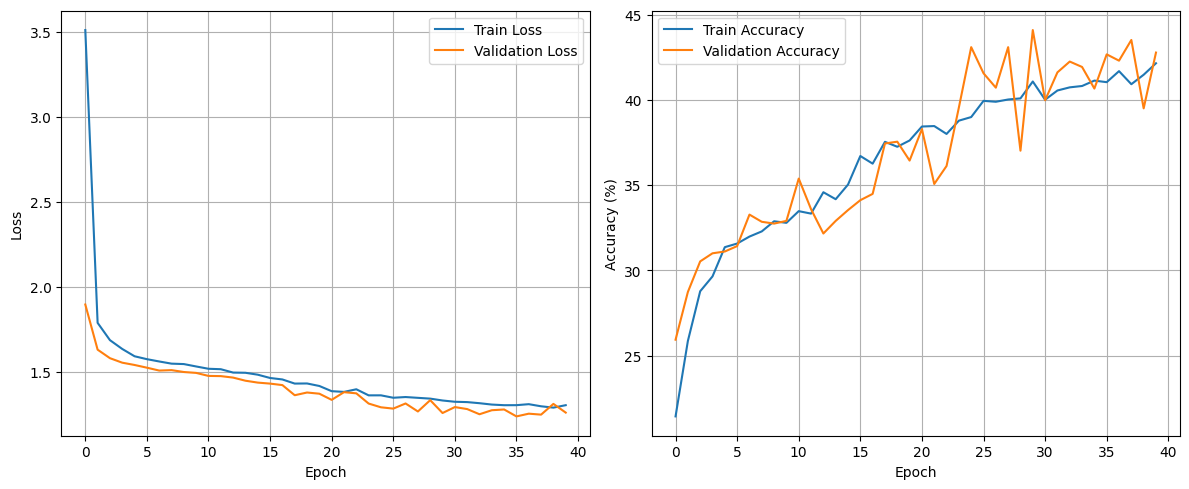

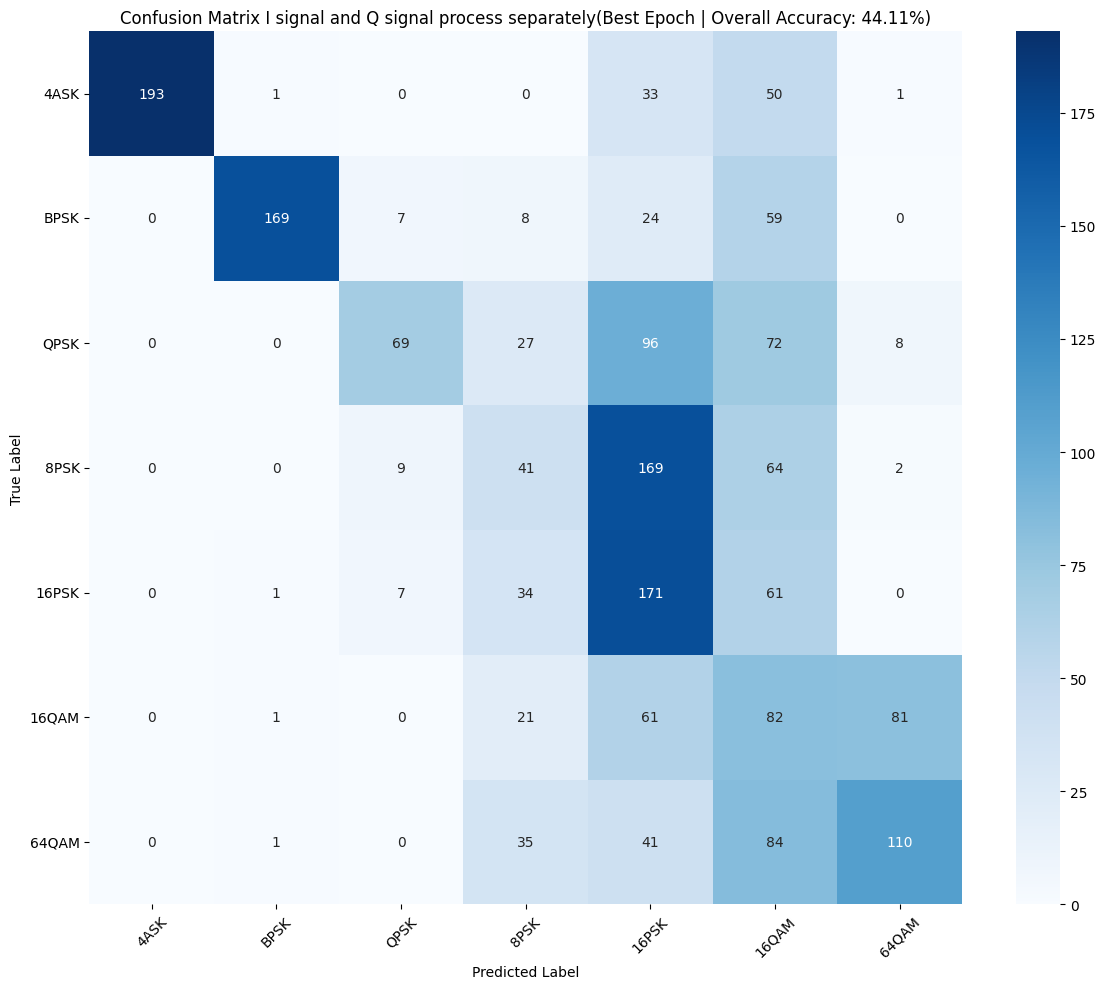

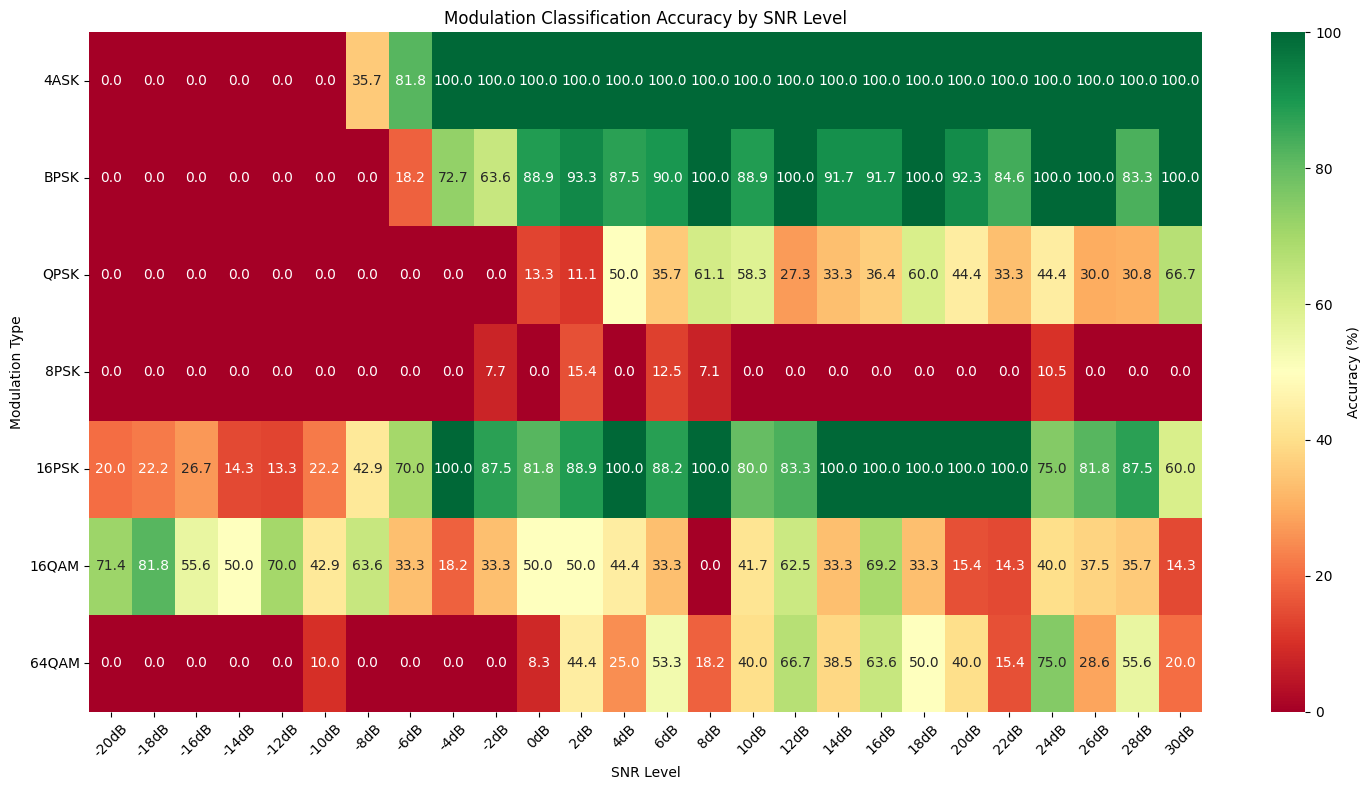

In [112]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNNIQ.parameters(), lr=0.0015, weight_decay=1e-4)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    patience=10, 
    factor=0.5,
    #verbose=True
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model2.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal process separately(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('Modulation Classification Accuracy by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatmap.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNIQ, valid_loader, device, TARGET_MODULATIONS)

C:\Users\N208\AppData\Local\Temp\ipykernel_10948\552402522.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
Dataset configured to use FFT as input
Datasets loaded successfully.
Total dataset size: 12792
Train dataset size: 8954 (80%)
Validation dataset size: 3838 (20%)

Starting training...


Training:   0%|                      | 0/35 [00:00<?, ?it/s]C:\Users\N208\AppData\Local\Temp\ipykernel_10948\552402522.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

                                                            
Epochs:   1%|▎                                  | 1/100 [00:00<01:30,  1.10it/s]

Epoch 1/100: Train Loss: 1.4353 | Train Acc: 31.34% | Valid Loss: 1.4327 | Valid Acc: 30.80%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:   2%|▋                                  | 2/100 [00:01<01:18,  1.24it/s]

Epoch 2/100: Train Loss: 1.4266 | Train Acc: 31.63% | Valid Loss: 1.4352 | Valid Acc: 30.51%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:   3%|█                                  | 3/100 [00:02<01:15,  1.29it/s]

Epoch 3/100: Train Loss: 1.4217 | Train Acc: 31.99% | Valid Loss: 1.4332 | Valid Acc: 30.35%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:   4%|█▍                                 | 4/100 [00:03<01:12,  1.32it/s]

Epoch 4/100: Train Loss: 1.4276 | Train Acc: 31.32% | Valid Loss: 1.4384 | Valid Acc: 30.09%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:   5%|█▊                                 | 5/100 [00:03<01:11,  1.33it/s]

Epoch 5/100: Train Loss: 1.4200 | Train Acc: 31.43% | Valid Loss: 1.4353 | Valid Acc: 31.03%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:   6%|██                                 | 6/100 [00:04<01:10,  1.34it/s]

Epoch 6/100: Train Loss: 1.4217 | Train Acc: 31.48% | Valid Loss: 1.4497 | Valid Acc: 30.48%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:   7%|██▍                                | 7/100 [00:05<01:09,  1.35it/s]

Epoch 7/100: Train Loss: 1.4187 | Train Acc: 32.15% | Valid Loss: 1.4376 | Valid Acc: 30.75%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:   8%|██▊                                | 8/100 [00:06<01:08,  1.35it/s]

Epoch 8/100: Train Loss: 1.4162 | Train Acc: 32.19% | Valid Loss: 1.4496 | Valid Acc: 29.16%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:   9%|███▏                               | 9/100 [00:06<01:07,  1.34it/s]

Epoch 9/100: Train Loss: 1.4101 | Train Acc: 31.53% | Valid Loss: 1.4431 | Valid Acc: 30.46%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  10%|███▍                              | 10/100 [00:07<01:07,  1.34it/s]

Epoch 10/100: Train Loss: 1.4128 | Train Acc: 31.95% | Valid Loss: 1.4512 | Valid Acc: 31.11%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  11%|███▋                              | 11/100 [00:08<01:06,  1.34it/s]

Epoch 11/100: Train Loss: 1.4105 | Train Acc: 32.19% | Valid Loss: 1.4513 | Valid Acc: 29.99%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  12%|████                              | 12/100 [00:09<01:05,  1.34it/s]

Epoch 12/100: Train Loss: 1.4128 | Train Acc: 32.05% | Valid Loss: 1.4532 | Valid Acc: 30.59%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  13%|████▍                             | 13/100 [00:09<01:05,  1.34it/s]

Epoch 13/100: Train Loss: 1.4118 | Train Acc: 31.77% | Valid Loss: 1.4462 | Valid Acc: 29.78%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  14%|████▊                             | 14/100 [00:10<01:03,  1.35it/s]

Epoch 14/100: Train Loss: 1.4093 | Train Acc: 31.89% | Valid Loss: 1.4405 | Valid Acc: 30.30%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  15%|█████                             | 15/100 [00:11<01:02,  1.35it/s]

Epoch 15/100: Train Loss: 1.4053 | Train Acc: 32.10% | Valid Loss: 1.4443 | Valid Acc: 29.94%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  16%|█████▍                            | 16/100 [00:12<01:02,  1.35it/s]

Epoch 16/100: Train Loss: 1.4026 | Train Acc: 32.08% | Valid Loss: 1.4565 | Valid Acc: 30.51%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  17%|█████▊                            | 17/100 [00:12<01:01,  1.35it/s]

Epoch 17/100: Train Loss: 1.3983 | Train Acc: 31.71% | Valid Loss: 1.4547 | Valid Acc: 31.47%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  18%|██████                            | 18/100 [00:13<01:00,  1.35it/s]

Epoch 18/100: Train Loss: 1.4010 | Train Acc: 32.26% | Valid Loss: 1.4648 | Valid Acc: 30.25%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  19%|██████▍                           | 19/100 [00:14<01:00,  1.34it/s]

Epoch 19/100: Train Loss: 1.3944 | Train Acc: 31.86% | Valid Loss: 1.4495 | Valid Acc: 30.93%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  20%|██████▊                           | 20/100 [00:14<00:59,  1.34it/s]

Epoch 20/100: Train Loss: 1.3933 | Train Acc: 31.94% | Valid Loss: 1.4563 | Valid Acc: 30.22%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  21%|███████▏                          | 21/100 [00:15<00:58,  1.35it/s]

Epoch 21/100: Train Loss: 1.4029 | Train Acc: 32.09% | Valid Loss: 1.4687 | Valid Acc: 30.80%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  22%|███████▍                          | 22/100 [00:16<00:57,  1.35it/s]

Epoch 22/100: Train Loss: 1.3985 | Train Acc: 32.42% | Valid Loss: 1.4592 | Valid Acc: 29.70%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  23%|███████▊                          | 23/100 [00:17<00:56,  1.36it/s]

Epoch 23/100: Train Loss: 1.3868 | Train Acc: 32.52% | Valid Loss: 1.4726 | Valid Acc: 30.17%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  24%|████████▏                         | 24/100 [00:17<00:55,  1.37it/s]

Epoch 24/100: Train Loss: 1.3896 | Train Acc: 32.78% | Valid Loss: 1.4619 | Valid Acc: 30.02%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  25%|████████▌                         | 25/100 [00:18<00:54,  1.36it/s]

Epoch 25/100: Train Loss: 1.3930 | Train Acc: 32.31% | Valid Loss: 1.4471 | Valid Acc: 30.90%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  26%|████████▊                         | 26/100 [00:19<00:54,  1.36it/s]

Epoch 26/100: Train Loss: 1.3853 | Train Acc: 32.67% | Valid Loss: 1.4890 | Valid Acc: 30.28%



Training:   0%|                      | 0/35 [00:00<?, ?it/s]
                                                            
Epochs:  26%|████████▊                         | 26/100 [00:20<00:57,  1.29it/s]


Early stopping at epoch 27

Training complete.
Best validation accuracy: 31.47%


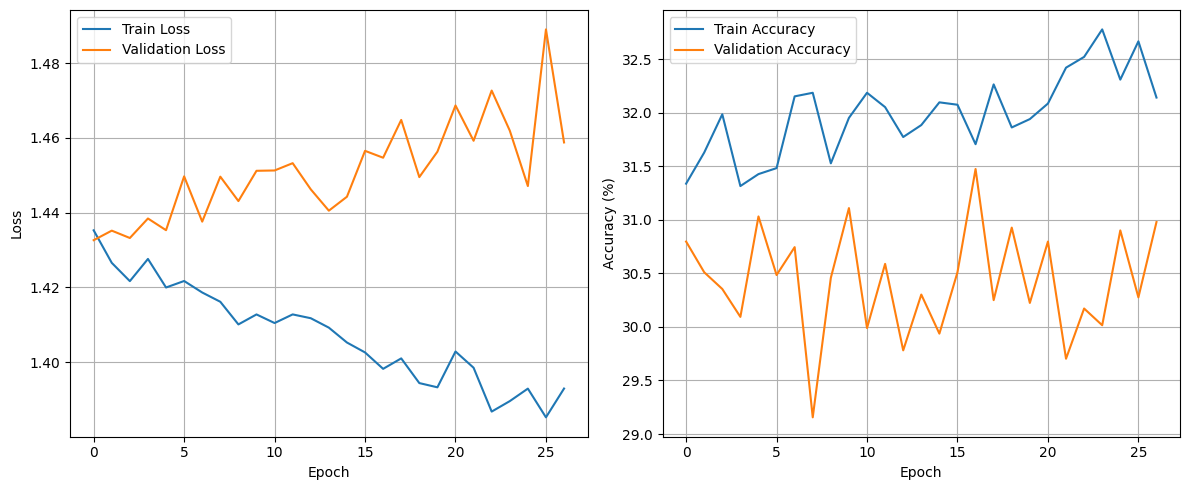

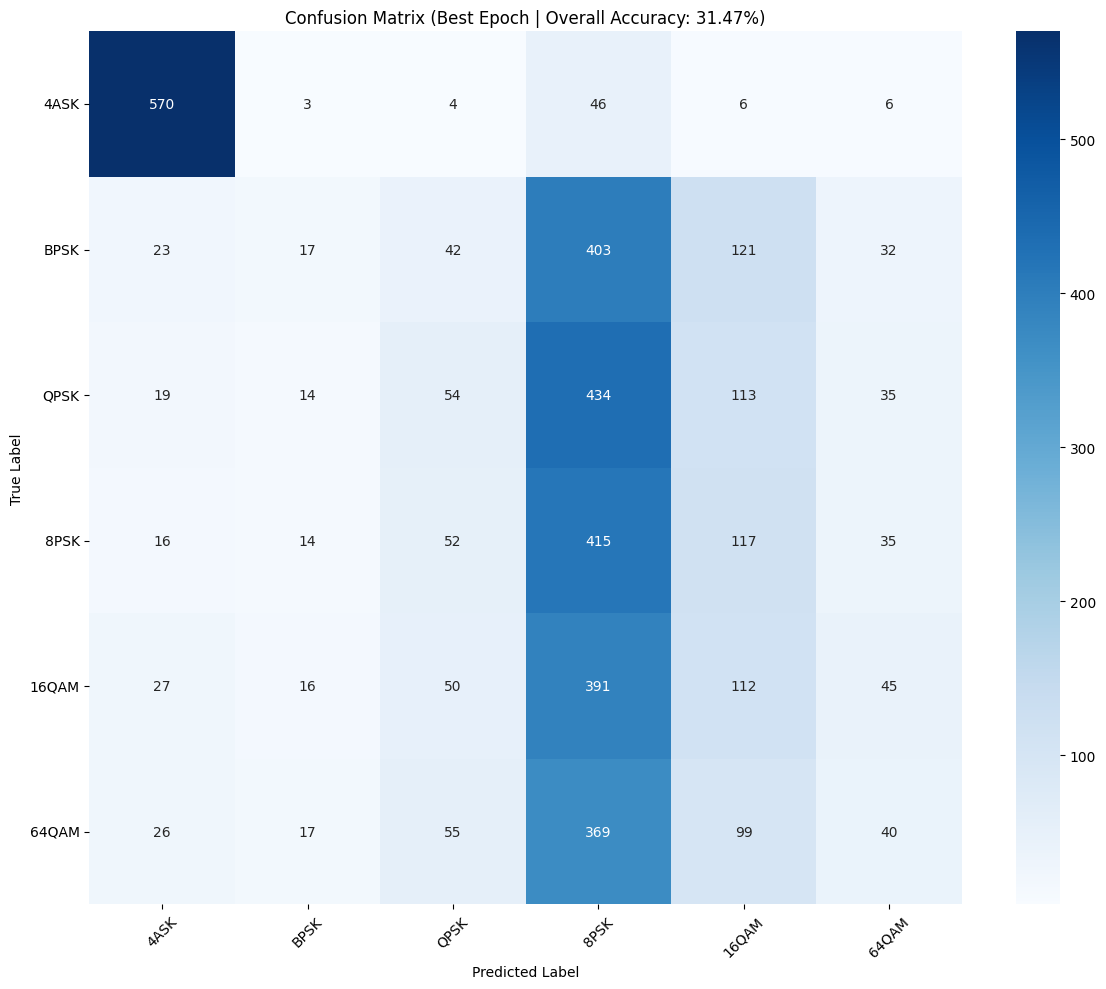

In [100]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    patience=10, 
    factor=0.5,
    #verbose=True
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioML18Dataset('train', use_fft=True)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model2.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_complex.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_complex.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix FFT apply (Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix.png')
plt.show()

In [42]:
class SignalAugmentation:
    """
    Comprehensive augmentation suite for I/Q signal processing
    Specifically designed for modulation classification
    """
    
    def __init__(self, config=None):
        # Default augmentation configuration
        self.config = config or {
            'noise_std_range': (0.01, 0.05),            # AWGN noise
            'snr_range': (-10, 30),                     # SNR variation
            'phase_shift_range': (-np.pi, np.pi),       # Phase rotation
            'amplitude_scale_range': (0.7, 1.3),        # Amplitude scaling
            'frequency_shift_range': (-0.1, 0.1),       # Frequency offset
            'time_shift_range': (-50, 50),              # Time shifting
            'iq_imbalance_range': (0.9, 1.1),           # I/Q imbalance
            'dc_offset_range': (-0.1, 0.1),             # DC offset
            'multipath_delay_range': (1, 10),           # Multipath fading
            'dropout_prob_range': (0.0, 0.02),          # Sample dropout
        }
    
    def add_awgn_noise(self, signal, probability=0.8):
        """Add Additive White Gaussian Noise"""
        if torch.rand(1).item() < probability:
            std_min, std_max = self.config['noise_std_range']
            noise_std = torch.empty(1).uniform_(std_min, std_max).item()
            
            # Add complex noise to both I and Q channels
            noise = torch.randn_like(signal) * noise_std
            return signal + noise
        return signal
    
    def snr_variation(self, signal, probability=0.6):
        """Simulate different SNR conditions"""
        if torch.rand(1).item() < probability:
            snr_min, snr_max = self.config['snr_range']
            target_snr_db = torch.empty(1).uniform_(snr_min, snr_max).item()
            
            # Calculate current signal power
            signal_power = torch.mean(signal ** 2)
            
            # Calculate required noise power for target SNR
            snr_linear = 10 ** (target_snr_db / 10)
            noise_power = signal_power / snr_linear
            
            # Add noise
            noise = torch.randn_like(signal) * torch.sqrt(noise_power)
            return signal + noise
        return signal
    
    def phase_rotation(self, signal, probability=0.7):
        """Apply random phase rotation (common in RF systems)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            phase_min, phase_max = self.config['phase_shift_range']
            phase_shift = torch.empty(1).uniform_(phase_min, phase_max).item()
            
            # Apply rotation matrix to I/Q
            cos_phi = np.cos(phase_shift)
            sin_phi = np.sin(phase_shift)
            
            i_rotated = signal[0] * cos_phi - signal[1] * sin_phi
            q_rotated = signal[0] * sin_phi + signal[1] * cos_phi
            
            return torch.stack([i_rotated, q_rotated], dim=0)
        return signal
    
    def amplitude_scaling(self, signal, probability=0.6):
        """Apply random amplitude scaling (AGC effects)"""
        if torch.rand(1).item() < probability:
            scale_min, scale_max = self.config['amplitude_scale_range']
            scale_factor = torch.empty(1).uniform_(scale_min, scale_max).item()
            return signal * scale_factor
        return signal
    
    def frequency_offset(self, signal, probability=0.5):
        """Simulate carrier frequency offset"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            freq_min, freq_max = self.config['frequency_shift_range']
            freq_offset = torch.empty(1).uniform_(freq_min, freq_max).item()
            
            # Create time vector
            seq_len = signal.size(1)
            t = torch.arange(seq_len, dtype=torch.float32) / seq_len
            
            # Apply frequency offset
            complex_offset = torch.exp(1j * 2 * np.pi * freq_offset * t)
            
            # Convert to I/Q and apply
            cos_offset = torch.real(complex_offset)
            sin_offset = torch.imag(complex_offset)
            
            i_shifted = signal[0] * cos_offset - signal[1] * sin_offset
            q_shifted = signal[0] * sin_offset + signal[1] * cos_offset
            
            return torch.stack([i_shifted, q_shifted], dim=0)
        return signal
    
    def time_shifting(self, signal, probability=0.4):
        """Apply random time shifts (timing offset)"""
        if torch.rand(1).item() < probability:
            shift_min, shift_max = self.config['time_shift_range']
            shift = torch.randint(shift_min, shift_max + 1, (1,)).item()
            
            if shift != 0:
                # Circular shift
                return torch.roll(signal, shifts=shift, dims=1)
        return signal
    
    def iq_imbalance(self, signal, probability=0.3):
        """Simulate I/Q imbalance (hardware imperfection)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            imb_min, imb_max = self.config['iq_imbalance_range']
            
            # Different scaling for I and Q channels
            i_scale = torch.empty(1).uniform_(imb_min, imb_max).item()
            q_scale = torch.empty(1).uniform_(imb_min, imb_max).item()
            
            signal_aug = signal.clone()
            signal_aug[0] *= i_scale  # I channel
            signal_aug[1] *= q_scale  # Q channel
            
            return signal_aug
        return signal
    
    def dc_offset(self, signal, probability=0.3):
        """Add DC offset (hardware bias)"""
        if torch.rand(1).item() < probability:
            offset_min, offset_max = self.config['dc_offset_range']
            
            # Different DC offset for each channel
            dc_i = torch.empty(1).uniform_(offset_min, offset_max).item()
            dc_q = torch.empty(1).uniform_(offset_min, offset_max).item()
            
            signal_aug = signal.clone()
            signal_aug[0] += dc_i
            signal_aug[1] += dc_q
            
            return signal_aug
        return signal
    
    def multipath_fading(self, signal, probability=0.2):
        """Simulate simple multipath fading"""
        if torch.rand(1).item() < probability:
            delay_min, delay_max = self.config['multipath_delay_range']
            delay = torch.randint(delay_min, delay_max + 1, (1,)).item()
            
            # Create delayed and attenuated copy
            attenuation = torch.empty(1).uniform_(0.1, 0.4).item()
            delayed_signal = torch.roll(signal, shifts=delay, dims=1) * attenuation
            
            return signal + delayed_signal
        return signal
    
    def sample_dropout(self, signal, probability=0.1):
        """Randomly drop some samples (simulate packet loss)"""
        if torch.rand(1).item() < probability:
            dropout_min, dropout_max = self.config['dropout_prob_range']
            dropout_prob = torch.empty(1).uniform_(dropout_min, dropout_max).item()
            
            # Create dropout mask
            mask = torch.rand(signal.size()) > dropout_prob
            return signal * mask
        return signal
    
    def spectral_inversion(self, signal, probability=0.2):
        """Apply spectral inversion (Q channel sign flip)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            signal_aug = signal.clone()
            signal_aug[1] *= -1  # Flip Q channel
            return signal_aug
        return signal
    
    def __call__(self, signal, augmentation_strength=1.0):
        """
        Apply random combination of augmentations
        
        Args:
            signal: Input I/Q signal tensor (2, seq_len)
            augmentation_strength: Float 0-1, controls how aggressive augmentation is
        """
        
        # Adjust probabilities based on strength
        strength_factor = min(max(augmentation_strength, 0.0), 1.0)
        
        # Apply augmentations in logical order
        augmented = signal.clone()
        
        # Hardware imperfections (apply early)
        augmented = self.dc_offset(augmented, probability=0.3 * strength_factor)
        augmented = self.iq_imbalance(augmented, probability=0.3 * strength_factor)
        
        # Channel effects
        augmented = self.phase_rotation(augmented, probability=0.7 * strength_factor)
        augmented = self.frequency_offset(augmented, probability=0.5 * strength_factor)
        augmented = self.amplitude_scaling(augmented, probability=0.6 * strength_factor)
        
        # Noise and interference
        augmented = self.add_awgn_noise(augmented, probability=0.8 * strength_factor)
        augmented = self.multipath_fading(augmented, probability=0.2 * strength_factor)
        
        # Timing effects
        augmented = self.time_shifting(augmented, probability=0.4 * strength_factor)
        
        # Digital effects
        augmented = self.sample_dropout(augmented, probability=0.1 * strength_factor)
        augmented = self.spectral_inversion(augmented, probability=0.2 * strength_factor)
        
        return augmented

In [43]:
def get_augmentation_presets():
    """
    Get predefined augmentation configurations for different scenarios
    """
    
    presets = {
        'conservative': {
            'noise_std_range': (0.005, 0.02),
            'snr_range': (0, 25),
            'phase_shift_range': (-np.pi/4, np.pi/4),
            'amplitude_scale_range': (0.8, 1.2),
            'frequency_shift_range': (-0.05, 0.05),
            'time_shift_range': (-20, 20),
            'iq_imbalance_range': (0.95, 1.05),
            'dc_offset_range': (-0.05, 0.05),
            'multipath_delay_range': (1, 5),
            'dropout_prob_range': (0.0, 0.01),
        },
        
        'moderate': {
            'noise_std_range': (0.01, 0.05),
            'snr_range': (-5, 30),
            'phase_shift_range': (-np.pi/2, np.pi/2),
            'amplitude_scale_range': (0.7, 1.3),
            'frequency_shift_range': (-0.1, 0.1),
            'time_shift_range': (-50, 50),
            'iq_imbalance_range': (0.9, 1.1),
            'dc_offset_range': (-0.1, 0.1),
            'multipath_delay_range': (1, 10),
            'dropout_prob_range': (0.0, 0.02),
        },
        
        'aggressive': {
            'noise_std_range': (0.02, 0.1),
            'snr_range': (-10, 35),
            'phase_shift_range': (-np.pi, np.pi),
            'amplitude_scale_range': (0.5, 1.5),
            'frequency_shift_range': (-0.2, 0.2),
            'time_shift_range': (-100, 100),
            'iq_imbalance_range': (0.8, 1.2),
            'dc_offset_range': (-0.2, 0.2),
            'multipath_delay_range': (1, 20),
            'dropout_prob_range': (0.0, 0.05),
        }
    }
    
    return presets

In [44]:
class RadioML18DatasetAugmented(Dataset):
    """
    Custom Dataset class for the RadioML2018.01.A dataset.
    Handles data loading, I/Q channel correction, optional FFT,
    and now includes optional Signal Augmentation for training data.
    """
    def __init__(self, mode: str, use_fft: bool = False, apply_augmentation: bool = False, augmentation_config=None, seed=48):
        super(RadioML18DatasetAugmented, self).__init__()

        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode

        # Augmentation setup
        self.apply_augmentation = apply_augmentation
        if self.apply_augmentation:
            self.augmentor = SignalAugmentation(config=augmentation_config)
            print(f"Dataset '{self.mode}' configured with Signal Augmentation.")
        else:
            self.augmentor = None
            print(f"Dataset '{self.mode}' configured WITHOUT Signal Augmentation.")


        try:
            hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except Exception as e: 
            print(f"Error loading file : {e}")
            raise e 
        
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]

        train_prop_ds = 0.7
        valid_prop_ds = 0.2
        test_prop_ds = 0.1

        self.target_snrs = np.unique(self.Z)

        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_prop_ds,
                                                                  valid_proportion = valid_prop_ds,
                                                                  test_proportion = test_prop_ds,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )
        
        print(f"🔧 Applying I/Q swap fix to {self.mode} dataset...")
        self.X_data = self.X_data[:,:,[1,0]] # Swapping I and Q channels
        print(f"✅ I/Q channels corrected for real-world compatibility for {self.mode} dataset.")
        
        if self.use_fft:
            print(f"Dataset '{self.mode}' configured to use FFT as input.")

        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x_raw, y, z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        
        # Convert to tensor and transpose to (channels, sequence length)
        x = torch.from_numpy(x_raw).float().transpose(0,1)

        # Apply augmentation ONLY for training mode if enabled
        if self.mode == 'train' and self.apply_augmentation and self.augmentor:
            x = self.augmentor(x, augmentation_strength=1.0) # Using full strength, can be tuned

        if self.use_fft: 
            complex_signal = torch.complex(x[0], x[1])
            fft_result = torch.fft.fft(complex_signal)
            fft_real = torch.real(fft_result)
            fft_imag = torch.imag(fft_result)
            x = torch.stack([fft_real, fft_imag], dim = 0)
        
        return x, y, z

In [ ]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    patience=7, 
    factor=0.5,
    #verbose=True
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
full_dataset = RadioML18DatasetAugmented('train', use_fft=False,apply_augmentation=True,augmentation_config=get_augmentation_presets()['conservative'])
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model2.pth'

# Store predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("🚀 Starting Training...")
print("=" * 80)
print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<11} {'Valid Loss':<12} {'Valid Acc':<11} {'Time':<8} {'Status'}")
print("=" * 80)

start_time = time.time()  # Track total training time

for epoch in range(NUM_EPOCHS):  # Ensure 'epochs' is defined
    epoch_start = time.time()
    
    # Training Phase
    model_complex.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    
    for batch_idx, (inputs, labels, _) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with autocast():
            outputs = model_complex(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        if batch_idx % (len(train_loader) // 4) == 0 and batch_idx > 0:
            progress = (batch_idx / len(train_loader)) * 100
            print(f"\r  Training: {progress:.0f}%", end='', flush=True)
    
    # Validation Phase  
    model_complex.eval()
    valid_loss, valid_correct, valid_total = 0.0, 0, 0
    epoch_predictions = []  # Store current epoch predictions
    epoch_labels = []       # Store current epoch labels
    
    with torch.no_grad():
        for inputs, labels, _ in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_complex(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
            
            # Collect for confusion matrix
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_valid_loss = valid_loss / len(valid_loader.dataset)
    epoch_train_acc = 100. * train_correct / train_total
    epoch_valid_acc = 100. * valid_correct / valid_total
    
    # Store metrics
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
    train_accuracies.append(epoch_train_acc)
    valid_accuracies.append(epoch_valid_acc)
    
    # Learning rate scheduling
    scheduler.step(epoch_valid_acc)
    
    # Early stopping check
    if epoch_valid_acc > best_accuracy:
        best_accuracy = epoch_valid_acc
        patience_counter = 0
        torch.save(model_complex.state_dict(), BEST_MODEL_PATH)
        # Save best epoch predictions/labels
        final_predictions = epoch_predictions
        final_true_labels = epoch_labels
        status = "💾 BEST"
    else:
        patience_counter += 1
        if patience_counter >= patience:
            status = "⏹️ STOP"
        else:
            status = f"⏳ {patience_counter}/{patience}"
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print epoch summary
    print(f"\r{epoch+1:<6} {epoch_train_loss:<12.4f} {epoch_train_acc:<11.2f} {epoch_valid_loss:<12.4f} {epoch_valid_acc:<11.2f} {epoch_time:<8.1f}s {status}")
    
    # Early stopping
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

total_time = time.time() - start_time
print("=" * 80)
print(f"✅ Training Complete! Best Accuracy: {best_accuracy:.2f}% | Total Time: {total_time/60:.1f} min")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix ---
# Ensure TARGET_MODULATIONS is defined (list of class names)
if len(final_predictions) > 0 and len(final_true_labels) > 0:
    cm = confusion_matrix(final_true_labels, final_predictions)
    accuracy = 100. * np.diag(cm).sum() / cm.sum()

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=TARGET_MODULATIONS, 
                yticklabels=TARGET_MODULATIONS)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix With Signal Augmentation conservative (Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('best_confusion_matrix.png')
    plt.show()
else:
    print("Warning: No predictions available for confusion matrix")

In [48]:
class RadioMLIQDatasetAugmented(Dataset):
    """Dataset class for RadioML18 data formatted for CNNIQModel dual-branch architecture.
    
    Loads RadioML18 HDF5 data and returns separate I and Q tensors in 2D format
    suitable for CNNIQModel's separate branch processing.
    """
    
    def __init__(self, mode: str, use_fft: bool = False, apply_augmentation: bool = False, augmentation_config=None, seed: int = 48):
        """Initialize RadioMLIQDataset.
        
        Args:
            mode: Dataset split mode ('train', 'valid', or 'test').
            use_fft: Whether to apply FFT transformation to signals.
            seed: Random seed for dataset splitting.
            
        Raises:
            FileNotFoundError: If HDF5 or JSON files cannot be found.
            ValueError: If mode is not valid or data dimensions are incompatible.
        """
        super(RadioMLIQDatasetAugmented, self).__init__()
        
        # Configuration (you'll need to define these constants)
        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode

        self.apply_augmentation = apply_augmentation
        if self.apply_augmentation:
            self.augmentor = SignalAugmentation(config=augmentation_config)
            print(f"Dataset '{self.mode}' configured with Signal Augmentation.")
        else:
            self.augmentor = None
            print(f"Dataset '{self.mode}' configured WITHOUT Signal Augmentation.")       
        # Validate mode
        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"Mode must be 'train', 'valid', or 'test', got '{mode}'")
        
        # Load data files
        try:
            self.hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Error loading data files: {e}")
        except Exception as e:
            print(f"Error loading file: {e}")
            raise e
        
        # Load raw data
        self.X = self.hdf5_file['X']
        self.Y = np.argmax(self.hdf5_file['Y'], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]
        
        # Calculate proportions for dataset splitting
        train_proportion = (13 * 26 * nf_train) / self.X.shape[0]
        valid_proportion = (13 * 26 * nf_valid) / self.X.shape[0]
        test_proportion = (13 * 26 * nf_test) / self.X.shape[0]
        
        self.target_snrs = np.unique(self.Z)
        
        # Split dataset
        self.X_data, self.Y_data, self.Z_data = dataset_split(
            data=self.X,
            modulations_classes=self.modulation_classes,
            modulations=self.Y,
            snrs=self.Z,
            mode=mode,
            train_proportion=train_proportion,
            valid_proportion=valid_proportion,
            test_proportion=test_proportion,
            target_modulations=self.target_modulations,
            target_snrs=self.target_snrs,
            seed=seed
        )
        
        # Apply I/Q swap correction for AMC compatibility
        print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
        self.X_data = self.X_data[:, :, [1, 0]]
        print(f"✅ I/Q channels corrected for real-world compatibility")
        
        # Validate signal length for 2D reshaping
        signal_length = self.X_data.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024 for 32x32 reshape, got {signal_length}")
        
        if self.use_fft:
            print("Dataset configured to use FFT as input")
        
        # Store dataset statistics
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
        print(f"RadioMLIQDataset {mode}: {self.num_data} samples, "
              f"{self.num_lbl} classes, {self.num_snr} SNR levels")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset.
        
        Returns:
            Number of samples.
        """
        return self.X_data.shape[0]
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int, float]:
        """Get a sample from the dataset.
        
        Args:
            idx: Sample index.
            
        Returns:
            Tuple of (i_tensor, q_tensor, label, snr) where:
                - i_tensor: I signal as 2D tensor (1, 32, 32)
                - q_tensor: Q signal as 2D tensor (1, 32, 32) 
                - label: Modulation class label
                - snr: Signal-to-noise ratio
                
        Raises:
            IndexError: If idx is out of range.
        """
        if idx >= len(self) or idx < 0:
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self)}")
        
        # Get raw data
        x_raw, y, z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        
        # Convert to tensor and transpose to (channels, sequence_length)
        x = torch.from_numpy(x_raw).float().transpose(0, 1)  # Shape: (2, 1024)
        
        # Apply FFT if requested
        if self.use_fft:
            complex_signal = torch.complex(x[0], x[1])
            fft_result = torch.fft.fft(complex_signal)
            fft_real = torch.real(fft_result)
            fft_imag = torch.imag(fft_result)
            x = torch.stack([fft_real, fft_imag], dim=0)
        
        # Separate I and Q signals
        i_signal = x[0]  # Shape: (1024,)
        q_signal = x[1]  # Shape: (1024,)
        
        # Reshape 1D signals to 2D (32x32) and add channel dimension
        i_2d = i_signal.view(1, 32, 32)  # Shape: (1, 32, 32)
        q_2d = q_signal.view(1, 32, 32)  # Shape: (1, 32, 32)
        
        return i_2d, q_2d, y, z
    
    def get_signal_stats(self) -> dict:
        """Get statistics about the signals in the dataset.
        
        Returns:
            Dictionary with signal statistics.
        """
        # Sample a few signals to compute stats
        sample_indices = np.random.choice(len(self), min(1000, len(self)), replace=False)
        i_values = []
        q_values = []
        
        for idx in sample_indices:
            i_2d, q_2d, _, _ = self[idx]
            i_values.append(i_2d.flatten())
            q_values.append(q_2d.flatten())
        
        i_all = torch.cat(i_values)
        q_all = torch.cat(q_values)
        
        return {
            'i_mean': float(i_all.mean()),
            'i_std': float(i_all.std()),
            'i_min': float(i_all.min()),
            'i_max': float(i_all.max()),
            'q_mean': float(q_all.mean()),
            'q_std': float(q_all.std()),
            'q_min': float(q_all.min()),
            'q_max': float(q_all.max()),
            'signal_shape': '(1, 32, 32)',
            'num_samples': len(self)
        }
    
    def close(self):
        """Close the HDF5 file handle."""
        if hasattr(self, 'hdf5_file'):
            self.hdf5_file.close()
    
    def __del__(self):
        """Cleanup when object is destroyed."""
        self.close()

C:\Users\N208\AppData\Local\Temp\ipykernel_10948\769414964.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
Dataset 'train' configured with Signal Augmentation.
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
RadioMLIQDataset train: 19968 samples, 8 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 19968
Train dataset size: 15974 (80%)
Validation dataset size: 3994 (20%)

Starting training...


Training:   0%|                      | 0/63 [00:00<?, ?it/s]C:\Users\N208\AppData\Local\Temp\ipykernel_10948\769414964.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training: 100%|█████████████| 63/63 [00:02<00:00, 32.02it/s]
                                                            
Epochs:   1%|▎                                  | 1/100 [00:02<03:40,  2.23s/it]

Epoch 1/100: Train Loss: 1.2926 | Train Acc: 44.97% | Valid Loss: 1.2889 | Valid Acc: 45.59%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.45it/s]
                                                            
Epochs:   2%|▋                                  | 2/100 [00:04<03:25,  2.09s/it]

Epoch 2/100: Train Loss: 1.2705 | Train Acc: 46.45% | Valid Loss: 1.2399 | Valid Acc: 44.97%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.84it/s]
                                                            
Epochs:   3%|█                                  | 3/100 [00:06<03:18,  2.05s/it]

Epoch 3/100: Train Loss: 1.2459 | Train Acc: 47.15% | Valid Loss: 1.2477 | Valid Acc: 48.65%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.50it/s]
                                                            
Epochs:   4%|█▍                                 | 4/100 [00:08<03:13,  2.01s/it]

Epoch 4/100: Train Loss: 1.2550 | Train Acc: 46.88% | Valid Loss: 1.2046 | Valid Acc: 48.60%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.53it/s]
                                                            
Epochs:   5%|█▊                                 | 5/100 [00:10<03:10,  2.01s/it]

Epoch 5/100: Train Loss: 1.2320 | Train Acc: 48.07% | Valid Loss: 1.2292 | Valid Acc: 45.09%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.48it/s]
                                                            
Epochs:   6%|██                                 | 6/100 [00:12<03:07,  1.99s/it]

Epoch 6/100: Train Loss: 1.2351 | Train Acc: 47.37% | Valid Loss: 1.1819 | Valid Acc: 51.85%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.46it/s]
                                                            
Epochs:   7%|██▍                                | 7/100 [00:14<03:04,  1.98s/it]

Epoch 7/100: Train Loss: 1.2228 | Train Acc: 48.67% | Valid Loss: 1.2024 | Valid Acc: 49.20%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.70it/s]
                                                            
Epochs:   8%|██▊                                | 8/100 [00:16<03:01,  1.98s/it]

Epoch 8/100: Train Loss: 1.2309 | Train Acc: 48.18% | Valid Loss: 1.1699 | Valid Acc: 52.23%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.54it/s]
                                                            
Epochs:   9%|███▏                               | 9/100 [00:18<02:59,  1.97s/it]

Epoch 9/100: Train Loss: 1.2072 | Train Acc: 49.59% | Valid Loss: 1.1756 | Valid Acc: 49.47%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.62it/s]
                                                            
Epochs:  10%|███▍                              | 10/100 [00:19<02:57,  1.97s/it]

Epoch 10/100: Train Loss: 1.2321 | Train Acc: 48.38% | Valid Loss: 1.1781 | Valid Acc: 50.13%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.63it/s]
                                                            
Epochs:  11%|███▋                              | 11/100 [00:21<02:55,  1.97s/it]

Epoch 11/100: Train Loss: 1.2018 | Train Acc: 50.06% | Valid Loss: 1.1467 | Valid Acc: 51.13%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.24it/s]
                                                            
Epochs:  12%|████                              | 12/100 [00:23<02:53,  1.98s/it]

Epoch 12/100: Train Loss: 1.1969 | Train Acc: 50.19% | Valid Loss: 1.1361 | Valid Acc: 55.41%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.20it/s]
                                                            
Epochs:  13%|████▍                             | 13/100 [00:25<02:52,  1.98s/it]

Epoch 13/100: Train Loss: 1.2164 | Train Acc: 49.32% | Valid Loss: 1.1467 | Valid Acc: 53.53%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.23it/s]
                                                            
Epochs:  14%|████▊                             | 14/100 [00:27<02:51,  1.99s/it]

Epoch 14/100: Train Loss: 1.2175 | Train Acc: 48.90% | Valid Loss: 1.1609 | Valid Acc: 49.82%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.16it/s]
                                                            
Epochs:  15%|█████                             | 15/100 [00:29<02:49,  1.99s/it]

Epoch 15/100: Train Loss: 1.2131 | Train Acc: 49.02% | Valid Loss: 1.3387 | Valid Acc: 42.11%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.28it/s]
                                                            
Epochs:  16%|█████▍                            | 16/100 [00:31<02:47,  2.00s/it]

Epoch 16/100: Train Loss: 1.2049 | Train Acc: 49.69% | Valid Loss: 1.1146 | Valid Acc: 54.38%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.37it/s]
                                                            
Epochs:  17%|█████▊                            | 17/100 [00:34<02:47,  2.02s/it]

Epoch 17/100: Train Loss: 1.2034 | Train Acc: 49.69% | Valid Loss: 1.1477 | Valid Acc: 52.40%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.37it/s]
                                                            
Epochs:  18%|██████                            | 18/100 [00:36<02:45,  2.01s/it]

Epoch 18/100: Train Loss: 1.1952 | Train Acc: 50.14% | Valid Loss: 1.1317 | Valid Acc: 52.10%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.77it/s]
                                                            
Epochs:  19%|██████▍                           | 19/100 [00:38<02:42,  2.01s/it]

Epoch 19/100: Train Loss: 1.1947 | Train Acc: 50.21% | Valid Loss: 1.1955 | Valid Acc: 46.70%



Training:  57%|███████▍     | 36/63 [00:01<00:00, 35.21it/s]
                                                            
Epochs:  20%|██████▊                           | 20/100 [00:40<02:40,  2.00s/it]

Epoch 20/100: Train Loss: 1.1948 | Train Acc: 50.09% | Valid Loss: 1.1385 | Valid Acc: 51.15%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.29it/s]
                                                            
Epochs:  21%|███████▏                          | 21/100 [00:42<02:38,  2.00s/it]

Epoch 21/100: Train Loss: 1.2024 | Train Acc: 49.82% | Valid Loss: 1.1595 | Valid Acc: 51.80%



Training:  56%|███████▏     | 35/63 [00:01<00:00, 34.80it/s]
                                                            
Epochs:  21%|███████▏                          | 21/100 [00:44<02:45,  2.10s/it]

Early stopping at epoch 22

Training complete.
Best validation accuracy: 55.41%


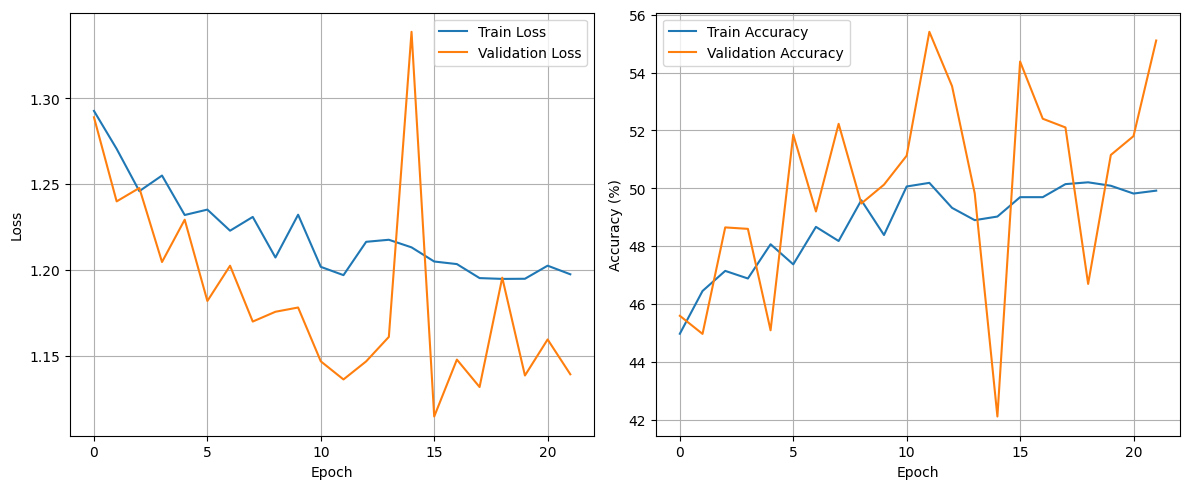

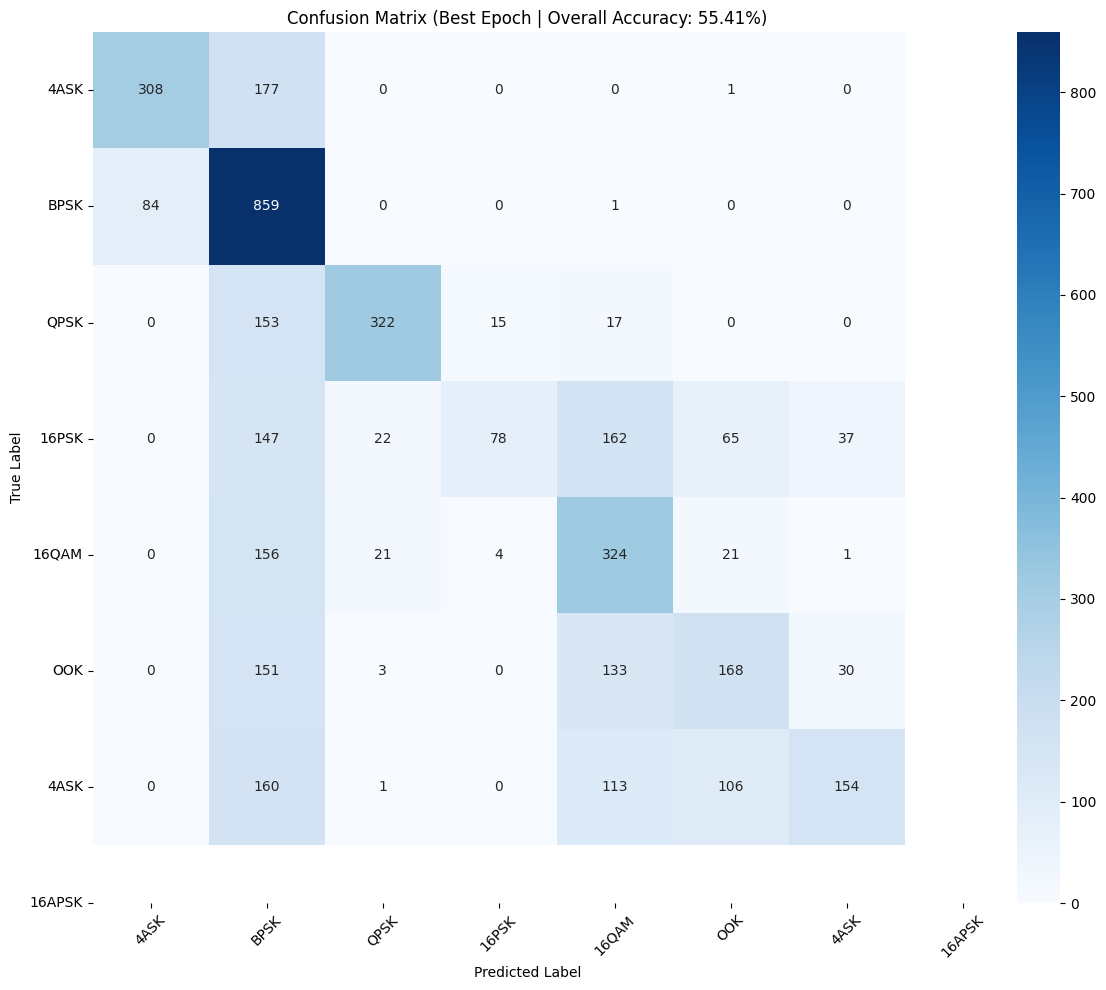

In [49]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNNIQ.parameters(), lr=0.01, weight_decay=5e-4)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    patience=10, 
    factor=0.5,
    #verbose=True
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDatasetAugmented('train', use_fft=False,apply_augmentation=True,augmentation_config=get_augmentation_presets()['conservative'])  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model2.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix.png')
plt.show()